In [1]:
import pandas as pd

input_filename = "C:\\Users\\Pc\\Downloads\\FR_CO2_2023.csv"
output_filename = "C:\\Users\\Pc\\Downloads\\CLEAN_FR_CO2_2023.csv"
titre_graph = "FR_C02_2023"

df = pd.read_csv(input_filename)

In [2]:
df.isna().sum()

ID                            0
Country                       0
VFN                           3
Mp                       133053
Mh                            0
Man                           0
MMS                     1889602
Tan                           1
T                             1
Va                            1
Ve                            2
Mk                            0
Cn                            0
Ct                            0
Cr                            0
r                             0
m (kg)                        1
Mt                            1
Enedc (g/km)            1889602
Ewltp (g/km)                  0
W (mm)                  1889602
At1 (mm)                1889602
At2 (mm)                1889602
Ft                            0
Fm                            0
ec (cm3)                 309734
ep (KW)                    3239
z (Wh/km)               1415328
IT                       578477
Ernedc (g/km)           1889602
Erwltp (g/km)            578477
De      

In [3]:
col_to_del = ['MMS', 'Enedc (g/km)', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'Ernedc (g/km)', 'De', 'Vf']

In [4]:
# colonnes à supprimer car pas assez remplies (à valider, on peut peut être aussi inclure IT et Erwltp (g/km))
col_to_del.append('RLFI')

In [5]:
# colonnes à supprimer car doublons d'information
col_to_del.extend(('Mp', 'Mh', 'Man', 'Cr', 'm (kg)', 'Fm'))

In [6]:
# colonnes à supprimer car non pertinentes (infos administratives ou relatives au jeu de données en lui-même)
col_to_del.extend(('ID', 'Status', 'r', 'year', 'Tan', 'Va', 'Ve', 'Ct', 'Cr'))

In [7]:
# suppression des lignes concernant les véhicules électriques ainsi que des colonnes concernant ces véhicules uniquement
df = df[df['Ft'] != 'electric']
col_to_del.append('Electric range (km)')

In [8]:
# suppresion de colonnes sélectionnées
df = df.drop(col_to_del, axis=1)

In [9]:
# suppresion des doublons
df = df.drop_duplicates()

In [10]:
df.head(5)

,Country,VFN,T,Mk,Cn,Mt,Ewltp (g/km),Ft,ec (cm3),ep (KW),z (Wh/km),IT,Erwltp (g/km),Date of registration,Fuel consumption,ech
0,FR,IP-JLA1N0PDW5A_002-VF1-1,RJL,RENAULT,ARKANA,1503.0,131,petrol,1332.0,103.0,NaN,e2 33 37,2.04,2023-06-02,5.8,6AP
1,FR,IP-0120-JT1-1,XA5P(S)(EU.M),SUZUKI,SUZUKI ACROSS,2162.0,22,petrol/electric,2487.0,136.0,166.0,NaN,NaN,2023-12-15,1.0,N.A.
2,FR,IP-HNS____ATN83445-VF3,M,PEUGEOT,3008,1610.0,148,petrol,1199.0,96.0,NaN,e2 29 37,2.00,2023-10-19,6.5,Euro 6 EA
3,FR,IP-03_312_0239-ZFA-1,312,FIAT,ABARTH 500,1198.0,152,petrol,1368.0,121.0,NaN,NaN,NaN,2023-01-30,6.7,Euro 6 AP
5,FR,IP-0000931-WBA-1,U1X,BMW,X1 SDRIVE18D,1787.0,134,diesel,1995.0,110.0,NaN,e24 29 37,1.88,2023-05-03,5.1,Euro 6 AP


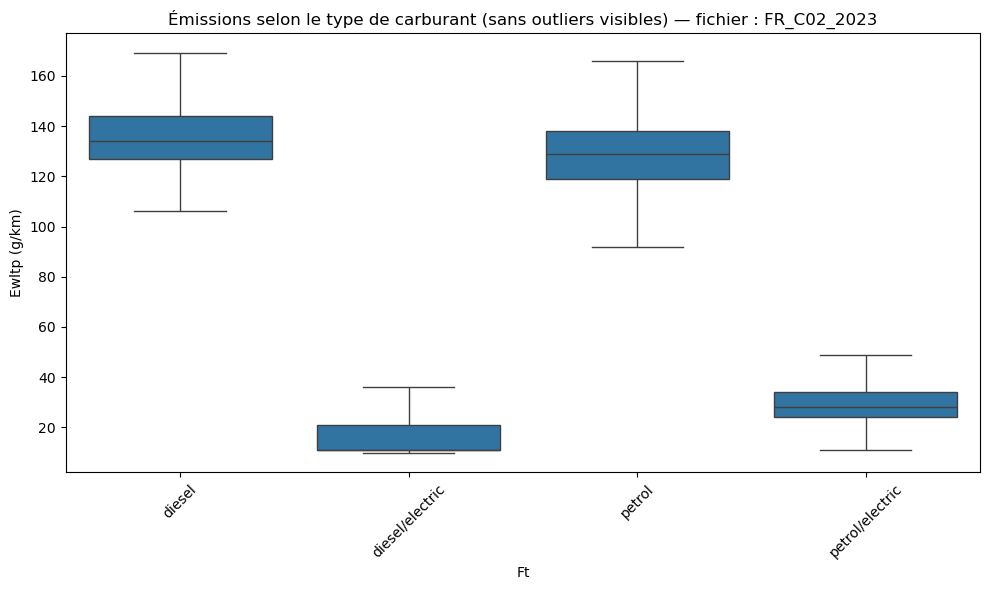

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Étape 1 : Exclusion des carburants rares
exclusions = ['lpg', 'e85', 'ng', 'hydrogen']
df_filtered = df[~df['Ft'].isin(exclusions)]

# Étape 2 : Suppression des outliers PAR groupe de carburant
def remove_outliers_iqr_per_group(df, group_col, value_col):
    df_clean = pd.DataFrame()
    for name, group in df.groupby(group_col):
        Q1 = group[value_col].quantile(0.25)
        Q3 = group[value_col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        group_clean = group[(group[value_col] >= lower) & (group[value_col] <= upper)]
        df_clean = pd.concat([df_clean, group_clean], axis=0)
    return df_clean.reset_index(drop=True)

df_no_outliers = remove_outliers_iqr_per_group(df_filtered, 'Ft', 'Ewltp (g/km)')



df_no_outliers.to_csv("{output_filename}", index=False)

# Étape 3 : Affichage final sans outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_no_outliers, x='Ft', y='Ewltp (g/km)', showfliers=False)

plt.title(f'Émissions selon le type de carburant (sans outliers visibles) — fichier : {titre_graph}')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

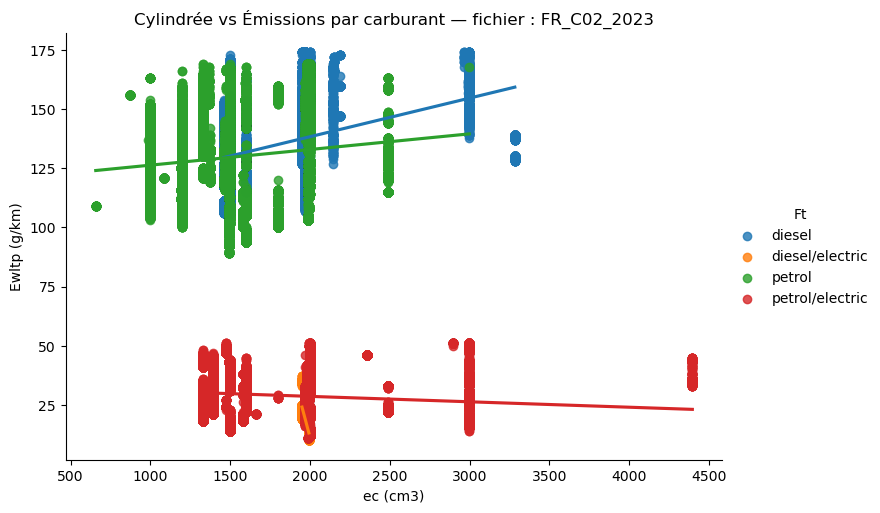

In [12]:
sns.lmplot(data=df_no_outliers, x='ec (cm3)', y='Ewltp (g/km)', hue='Ft', aspect=1.5)
plt.title(f'Cylindrée vs Émissions par carburant — fichier : {titre_graph}')
plt.show()

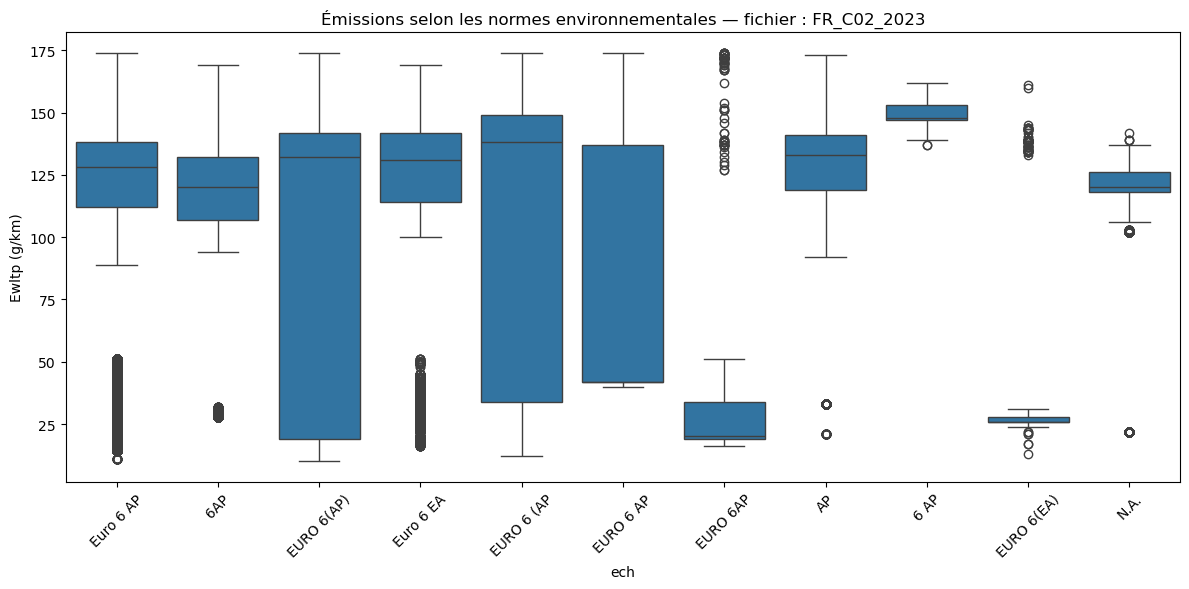

In [13]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_no_outliers, x='ech', y='Ewltp (g/km)')
plt.xticks(rotation=45)
plt.title(f'Émissions selon les normes environnementales — fichier : {titre_graph}')
plt.tight_layout()
plt.show()

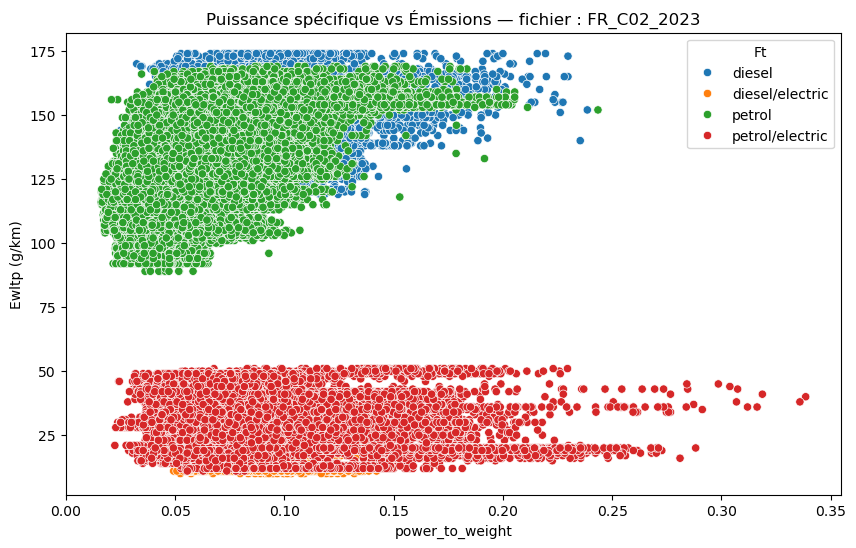

In [14]:
# Calcul de la puissance spécifique
df_no_outliers['power_to_weight'] = df_no_outliers['ep (KW)'] / df['Mt']
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_no_outliers, x='power_to_weight', y='Ewltp (g/km)', hue='Ft')
plt.title(f'Puissance spécifique vs Émissions — fichier : {titre_graph}')
plt.show()

In [15]:
top5_polluants = df_no_outliers.sort_values(by='Ewltp (g/km)', ascending=False).head(5)
top5_sobres = df_no_outliers.sort_values(by='Ewltp (g/km)', ascending=True).head(5)
print(titre_graph)
print("Top 5 véhicules les plus émetteurs :")
print(top5_polluants[['Mk', 'Cn', 'Ewltp (g/km)', 'Ft']])
print("\nTop 5 véhicules les plus sobres :")
print(top5_sobres[['Mk', 'Cn', 'Ewltp (g/km)', 'Ft']])

FR_C02_2023
Top 5 véhicules les plus émetteurs :
               Mk            Cn  Ewltp (g/km)      Ft
97082  VOLKSWAGEN        TIGUAN           174  diesel
42465        AUDI  Q5 SPORTBACK           174  diesel
32971        AUDI  Q5 SPORTBACK           174  diesel
84831        AUDI            Q5           174  diesel
51529  VOLKSWAGEN        TIGUAN           174  diesel

Top 5 véhicules les plus sobres :
                   Mk                 Cn  Ewltp (g/km)               Ft
114295  MERCEDES-BENZ  GLC 300 DE 4MATIC            10  diesel/electric
112084  MERCEDES-BENZ  GLC 300 DE 4MATIC            10  diesel/electric
112171  MERCEDES-BENZ  GLC 300 DE 4MATIC            10  diesel/electric
113616  MERCEDES-BENZ  GLC 300 DE 4MATIC            10  diesel/electric
111381  MERCEDES-BENZ  GLC 300 DE 4MATIC            10  diesel/electric


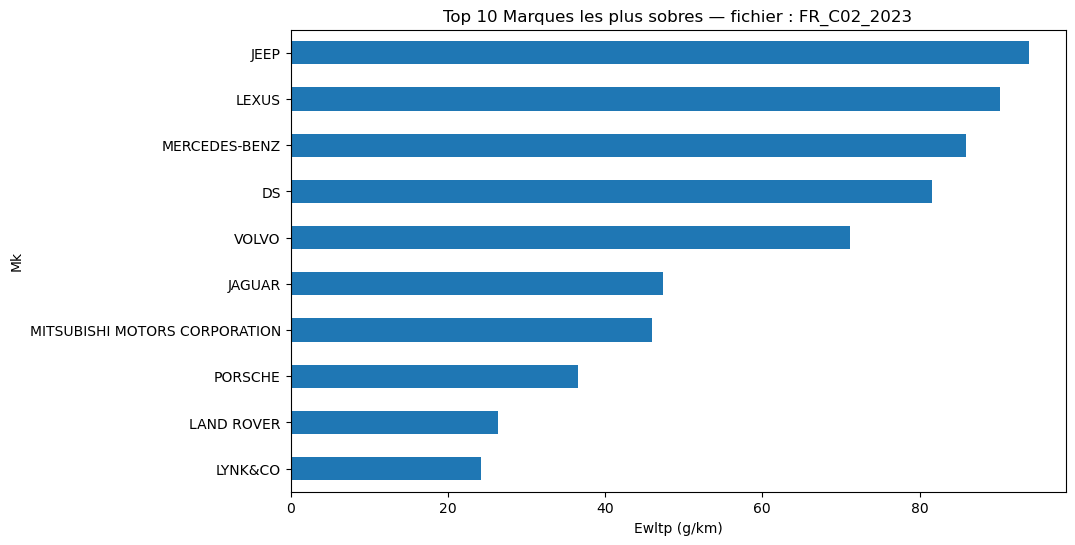

In [16]:
mean_emissions_by_brand = df_no_outliers.groupby('Mk')['Ewltp (g/km)'].mean().sort_values()
mean_emissions_by_brand.head(10).plot(kind='barh', figsize=(10, 6), title=f'Top 10 Marques les plus sobres — fichier : {titre_graph}')
plt.xlabel('Ewltp (g/km)')
plt.show()

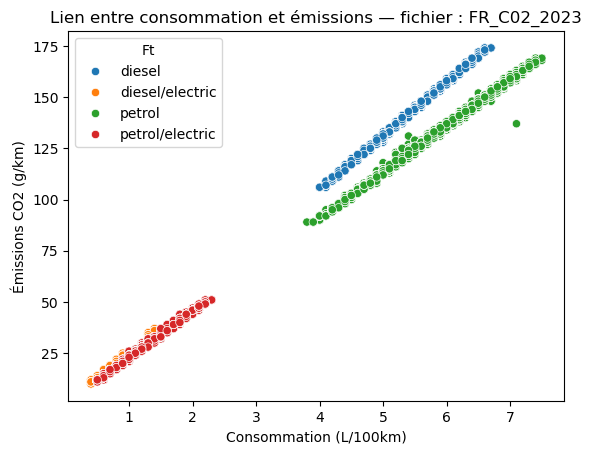

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
df_no_outliers.columns = df_no_outliers.columns.str.strip()

sns.scatterplot(data=df_no_outliers, 
                x='Fuel consumption', 
                y='Ewltp (g/km)', 
                hue='Ft')

plt.title(f'Lien entre consommation et émissions — fichier : {titre_graph}')
plt.xlabel('Consommation (L/100km)')
plt.ylabel('Émissions CO2 (g/km)')
plt.show()

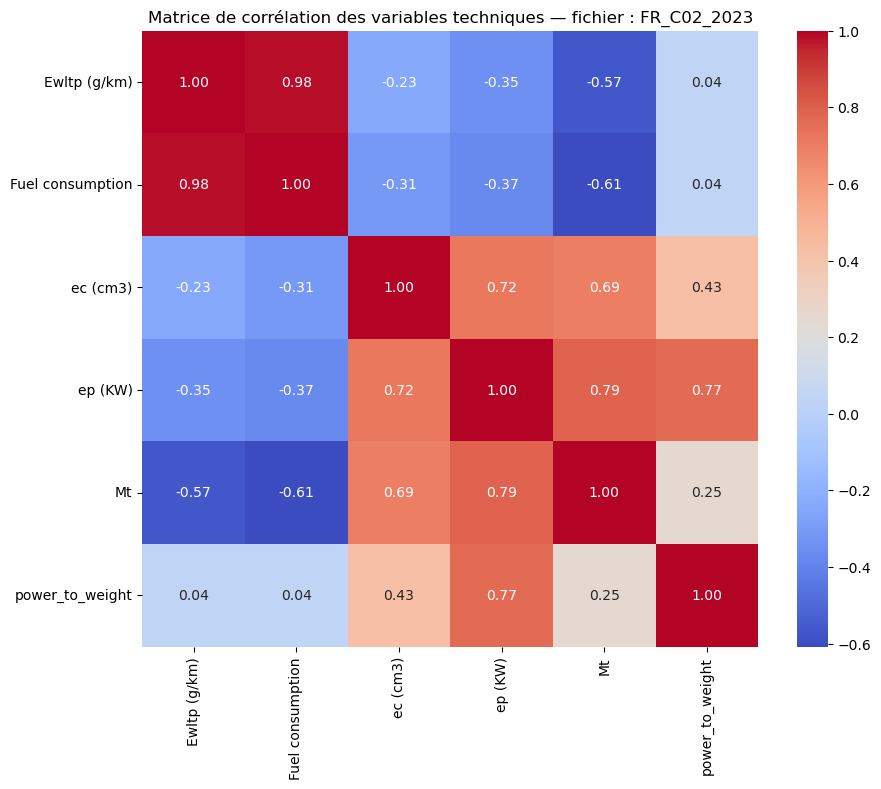

In [18]:
# Nettoyage éventuel des noms de colonnes
df_no_outliers.columns = df_no_outliers.columns.str.strip()


# Ajout de la puissance spécifique
df_no_outliers['power_to_weight'] = df_no_outliers['ep (KW)'] / df_no_outliers['Mt']

# Sélection des colonnes à corréler
colonnes_corr = ['Ewltp (g/km)', 'Fuel consumption', 'ec (cm3)', 'ep (KW)', 'Mt', 'power_to_weight']
df_no_outliers_corr = df_no_outliers[colonnes_corr].copy()

# Calcul de la matrice de corrélation
correlation_matrix = df_no_outliers_corr.corr()

# Affichage de la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title(f"Matrice de corrélation des variables techniques — fichier : {titre_graph}")
plt.show()